# Mirror Descent Experiments

## *This is not currently being improved or maintained.*

### Background  
[Stochastic Gradient / Mirror Descent: Minimax Optimality and Implicit Regularization](https://arxiv.org/pdf/1806.00952.pdf)

[Data-Driven Mirror Descent in Input-Convex Neural Networks](https://arxiv.org/pdf/2206.06733.pdf)


### Question

Above tells us that mirror descent on data $\{x_i, y_i\}$ with potential $\phi$ converges to $\operatorname*{argmin}_{w \in W^*} D_{\phi} (w \| w_0)$ (where $W^*$ is the set of weights that interpolate the data and $w_0$ is the intialization).

**Can we learn a useful data-dependent $\phi$ that improves generalization?**

### Roadmap

* Linear model: $y_i = w_*^\top x_i + \varepsilon_i$, potential $\phi(x) = x^\top Q x$
    * Verify that you learn a $Q$ with good val loss
    * How does learned $Q$ relate to $w_*$?
        * Can you write a closed-form expression for minimizer? How close do we get?
    * If you resample $w_* \sim \mathcal N(0, \Sigma)$, do you learn $\Sigma$?
    * Different loss functions (inner & outer loops; cross-validation)

* Linear model, more general choices of $\phi$
    * Exponential weights?
    * Input-convex neural network?
    * Non-convex "potentials"? (Do they break immediately? Do they tend to learn convex-ish things? Do they work better for some reason?)

* More realistic data (e.g. MNIST and scale up), general $\phi$ (ICNN?)

In [1]:
import numpy as np
from numpy.testing import assert_allclose
from scipy.linalg import solve_sylvester   # for UUT closed form optimum
from time import perf_counter

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # make plots a bit nicer by default

# custom imports
from plot_utils import plot_matrix_evolution


# Set global constant NOTEBOOK_START_TIME. This block is idempotent.
#  (only here so I can see how long it takes to run the whole notebook, which is occasionally useful)
if 'NOTEBOOK_START_TIME' in globals():
    print(f"Notebook start time: {NOTEBOOK_START_TIME:.2f}, which was {perf_counter() - NOTEBOOK_START_TIME:.2f} seconds ago.")  # type: ignore
else:
    NOTEBOOK_START_TIME = perf_counter()
    print(f"Notebook start time newly set to: {NOTEBOOK_START_TIME}")

Notebook start time newly set to: 670574.630953


# Generating data

In [2]:
def generate_linear_data(d_feature: int, n_samples: int, w_cov: np.ndarray | None = None, x_cov: np.ndarray | None = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e where X is (n_samples, d_feature) and w is (d_feature, 1).

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    if w_cov is None: w_cov = np.eye(d_feature)
    if x_cov is None: x_cov = np.eye(d_feature)
    
    w = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov)
    X = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=(n_samples,))
    assert X.shape == (n_samples, d_feature), f"X is the wrong size: {X.shape}, should be {(n_samples, d_feature)}"
    y = X @ w + np.random.normal(scale=noise_scale, size=(n_samples,))
    
    return X, y.ravel(), w


def generate_mixed_linear_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray | None = None, x_cov : np.ndarray | None = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w.
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    if w_cov is None: w_cov = np.eye(d_feature)
    if x_cov is None: x_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=x_cov, size=(n_samples_per_w * n_ws))
    y = np.concatenate([X[i * n_samples_per_w : (i+1) * n_samples_per_w] @ W[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W


def generate_specified_linear_data(n_samples_per_w: int, w_stars: np.ndarray, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for specified w vectors.

    Args:
        n_samples_per_w: Number of samples to generate for each w.
        w_stars: Array of weight vectors, shape (n_ws, d_feature).
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    n_ws, d_feature = w_stars.shape
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i*n_samples_per_w:(i+1)*n_samples_per_w] @ w_stars[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, w_stars


def generate_std_basis_data(d_feature: int, n_samples: int, w: np.ndarray = None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate (must be <= d_feature).
        w: True weight vector. If None, randomly generated.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    assert n_samples <= d_feature, "n_samples must be <= d_feature for standard basis vectors"
    
    if w is None:
        w = np.random.randn(d_feature)
    
    X = np.eye(d_feature)[:n_samples]
    y = (X @ w).ravel()
    
    return X, y, w


def generate_mixed_std_basis_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors, where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w (must be <= d_feature).
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    assert n_samples_per_w <= d_feature, "n_samples_per_w must be <= d_feature for standard basis vectors"
    
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.tile(np.eye(d_feature)[:n_samples_per_w], (n_ws, 1))
    y = np.concatenate([W[i, :n_samples_per_w] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W

# $Q$ parameterization: not ensuring psd or symmetric

## Basic training loop ✅

In [3]:
def mirror_descent_step(w, Q, lr, x, y):
    return w - 2 * lr * (np.inner(w,x) - y) * (Q @ x)


def mirror_descent_batch_step(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.

    Args:
        w: Current weight vector (d_feature, 1).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        X: Data matrix (batch_size, d_feature)
        y: Target values (batch_size)

    Returns:
        Updated weight vector (d_feature,).
    """
    # TODO: dividing by norm isn't principled but makes single-step plots better. think about this.
    return w - 2 * lr * Q @ X.T @ (X @ w - y) / X.shape[0]

def crossval(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    n, d = X.shape

    errors = X @ w - y  # (n_samples,)
    XQX = X @ Q.T @ X.T  # (n_samples, n_samples)
    L_squared = (errors - 2 * lr * errors[:, np.newaxis] * XQX)**2  # (n_samples, n_samples)
    
    # Enforcing i != j condition, if applicable
    if ignore_diag:
        np.fill_diagonal(L_squared, 0)
        denom = 2 * n * (n-1)
    else:
        denom = 2 * n**2
    
    return np.sum(L_squared) / denom  # average over all L_ij

def batch_crossval(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray, batch_size: int) -> float:
    """
    TODO: Not 100% sure this is right.
    TODO: might be nicer without the einsum
    """
    n, d = X.shape
    n_batches = n // batch_size   # if batch_size doesn't divide n, some datapoints will be unused
    X_batches = X[n_batches * batch_size].resize(n_batches, batch_size, d)

    n_batches = n // batch_size
    X_batches = X[:n_batches * batch_size]
    X_batches.resize((n_batches, batch_size, d))

    y_batches = y[:n_batches * batch_size]
    y_batches.resize((n_batches, batch_size))

    errors = X_batches @ w - y_batches

    return np.mean((errors - 2 * lr * np.einsum('ai, aig, dg, bjd -> bj', errors, X_batches, Q, X_batches))**2) / (n**2)
    
def potential_batch_update(w: np.ndarray, Q: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray, batch_size: int, ignore_diag=True) -> np.ndarray:
    """
    NOT TESTED YET

    Update the potential matrix Q based on the derivative of the cross-validation loss using batch processing.

    Args:
        w: Current weight vector (d_feature,).
        Q: Current potential matrix (d_feature, d_feature).
        outer_lr: Learning rate for updating Q.
        inner_lr: Learning rate for the inner mirror descent step.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).
        batch_size: Size of each batch.
        ignore_diag: Whether to ignore diagonal elements in the loss calculation.

    Returns:
        Updated potential matrix Q (d_feature, d_feature).
    """
    n, d = X.shape
    n_batches = n // batch_size
    
    # Reshape X and y into batches
    X_batches = X[:n_batches * batch_size].reshape(n_batches, batch_size, d)
    y_batches = y[:n_batches * batch_size].reshape(n_batches, batch_size)
    
    # Calculate errors for all batches
    errors = X_batches @ w - y_batches  # Shape: (n_batches, batch_size)
    
    # Calculate XQX for all batches
    XQX = np.einsum('bik,kj,bjl->bil', X_batches, Q.T, X_batches)  # Shape: (n_batches, batch_size, batch_size)
    
    # Calculate L for all batches
    L = errors[:, :, np.newaxis] - 2 * inner_lr * errors[:, np.newaxis, :] * XQX  # Shape: (n_batches, batch_size, batch_size)
    
    if ignore_diag:
        # Set diagonal elements to zero for each batch
        L[:, np.arange(batch_size), np.arange(batch_size)] = 0
        denom = n_batches * batch_size * (batch_size - 1)
    else:
        denom = n_batches * batch_size ** 2
    
    # Calculate the update
    L_errors = np.einsum('bji,bj->bi', L, errors)  # Shape: (n_batches, batch_size)
    update = np.einsum('bki,bj,bkj->ij', X_batches, L_errors, X_batches)  # Shape: (d_feature, d_feature)
    
    update *= -2 * inner_lr / denom
    return Q - outer_lr * update


def potential_update(w: np.ndarray, Q: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                     ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix Q based on the derivative of the cross-validation loss.

    Args:
        w: Current weight vector (d_feature,).
        Q: Current potential matrix (d_feature, d_feature).
        outer_lr: Learning rate for updating Q.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Updated potential matrix Q (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    
    errors = X @ w - y
    XQX = X @ Q.T @ X.T
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * XQX
    
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom = n_samples * (n_samples - 1)
    else:
        denom = n_samples ** 2
    
    # Corrected matrix operations to match the original einsum
    L_errors = L.T * errors  # (n_samples, n_samples)
    update = X.T @ L_errors @ X  # (d_feature, d_feature)
    
    update *= -2 * inner_lr / denom
    return Q - outer_lr * update

### `potential_training_loop`

In [4]:
def potential_training_loop_Q(X, y, inner_lr, outer_lr, w0, Q0, n_iters):
    """
    Basic training loop/
    """
    crossvals = []
    Q = Q0.copy()
    Qs = [Q0.copy()]
    for i in range(n_iters):
        crossvals.append(crossval(w0, Q, inner_lr, X, y, ignore_diag=False))
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)
        Qs.append(Q.copy())

    return np.array(crossvals), np.array(Qs)


def generate_data_and_train_Q(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                              w_cov=None, noise_scale=0., seed=None):
    """
    Simpler training loop, which also generates data to eliminate another line of code later on. 
    """
    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)
    crossvals, Qs = potential_training_loop_Q(X, y, inner_lr, outer_lr, w0, Q0, n_iters)

    return crossvals, Qs, X, y, w_star


def random_experiment_setup():
    d_feature = np.random.randint(5, 15)
    n_samples = np.random.randint(d_feature**1.25, d_feature**2.25)
    lr = np.random.uniform(0.01, 0.3)
    #noise_scale = np.random.uniform(0, 1)
    noise_scale = 0   # all noiseless for now

    X, y, w_star = generate_linear_data(d_feature, n_samples, noise_scale=noise_scale)

    w = np.random.randn(d_feature)
    Q = np.random.randn(d_feature, d_feature)

    return d_feature, n_samples, lr, X, y, w_star, w, Q

## Graphs for single $w$

### Closed-form solution

In [5]:
def stationary_closed_form(X, w, w_star, lr):
    z = w - w_star
    E = np.diag(X @ z)**2
    return np.outer(z, z) @ X.T @ X @ np.linalg.inv(X.T @ E @ X) / (2 * lr)


def stationarity_condition_Q_full(Q, X, w, w_star, lr, return_pair=False):
    errors = X @ (w - w_star)   # (n,)
    
    # TODO: would be nice to replace this einsum with something legible
    lhs = 2 * lr * np.einsum('j,ia,ab,jb,ik,jl->kl', errors**2, X, Q, X, X, X)

    XTe = X.T @ errors
    rhs = np.outer(XTe, XTe)  # (d,d)

    if return_pair:
        return lhs, rhs
    return lhs - rhs

#### Check correctness of closed-form solution

In [6]:
# set up Q_star
d, n, lr, X, y, w_star, w0, Q0 = random_experiment_setup()
Q_star = stationary_closed_form(X, w0, w_star, lr)

# check "stationarity condition"
lhs, rhs = stationarity_condition_Q_full(Q_star, X, w0, w_star, lr, return_pair=True)
assert_allclose(lhs, rhs)

# check empirically that it's stationary (next update step is ~no different)
outer_lr = 10 ** np.random.uniform(-3, -1)
assert_allclose(Q_star, potential_update(w0, Q_star, outer_lr, lr, X, y, ignore_diag=False))

### Experiments

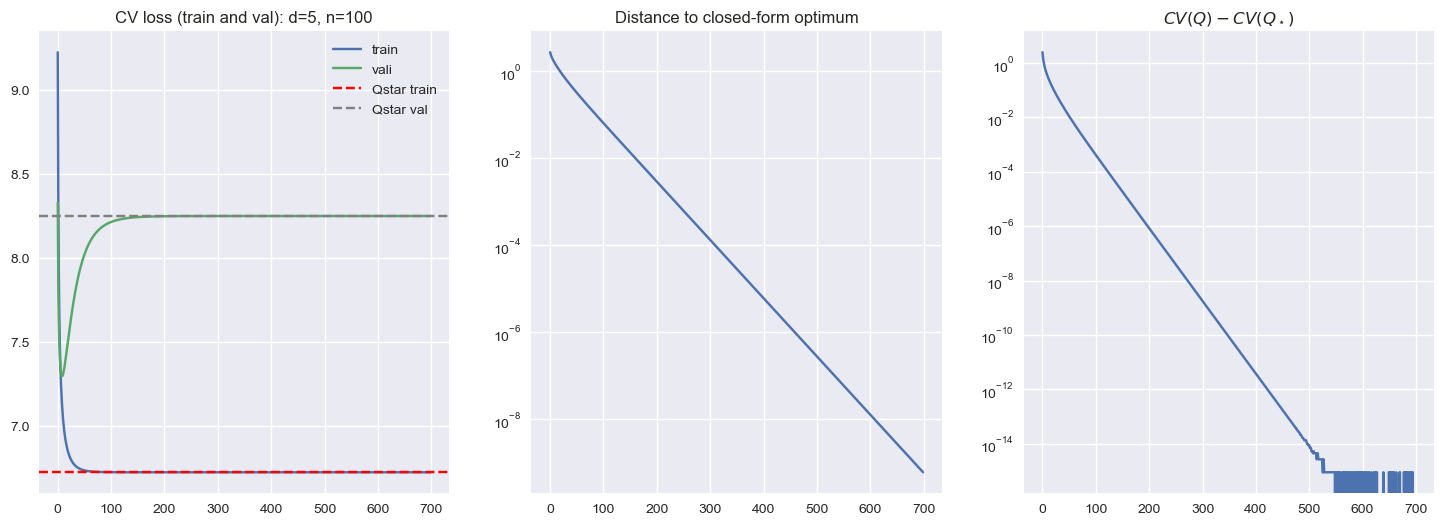

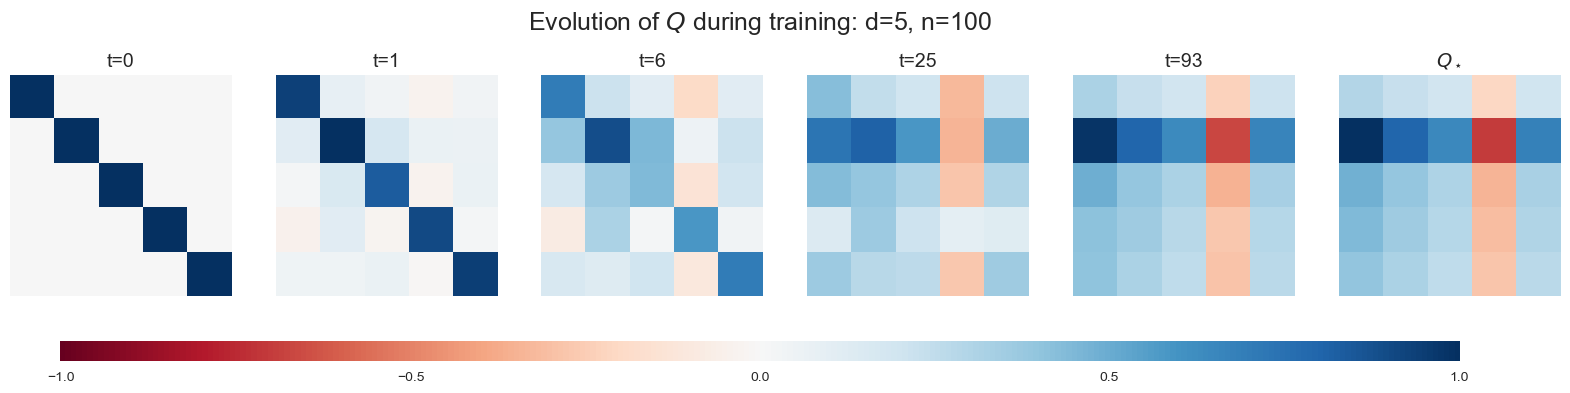

In [7]:
# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.15
n_iters = 700
w_cov = np.eye(d)
w0 = np.ones(d)
Q0 = np.eye(d)

# Training loop
crossvals, Qs, X, y, w_star = generate_data_and_train_Q(d, n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, seed=123)

# --- Plots ---
n_figures = 3
r = range(n_iters)   # range of indices to plot, separated out for easy modification
#r = range(n_iters//2)

# Compute stationarity gaps, crossvals on validation data
X_val = np.random.randn(n, d)
validation_crossvals = np.array([crossval(w0, Q, inner_lr, X_val, X_val @ w_star, ignore_diag=False) for Q in Qs[r]])

# Compute distance to optimum
Qstar = stationary_closed_form(X, w0, w_star, inner_lr)
d_Q_Qstar = np.linalg.norm(Qs - Qstar, axis=(1,2))

plt.figure(figsize=(n_figures * 6, 6))
# Plot crossvals
plt.subplot(1, n_figures, 1)
plt.title(f"CV loss (train and val): d={d}, n={n}")
plt.plot(crossvals[r], label="train")
plt.plot(validation_crossvals[r], label="vali")
plt.axhline(crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')
plt.axhline(crossval(w0, Qstar, inner_lr, X_val, X_val @ w_star, ignore_diag=False), label="Qstar val", linestyle='--', color='gray')
plt.legend()

# plot distance to optimum
plt.subplot(1, n_figures, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_Q_Qstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, n_figures, 3)
plt.title("$CV(Q) - CV(Q_\\star)$")
plt.plot(crossvals[r] - crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False))
plt.yscale('log')
plt.show()

plot_matrix_evolution(Qs[r], extra_matrix=Qstar, extra_matrix_title="$Q_\\star$", main_title=f"Evolution of $Q$ during training: d={d}, n={n}")

### $Q$, single $w$, nonzero noise

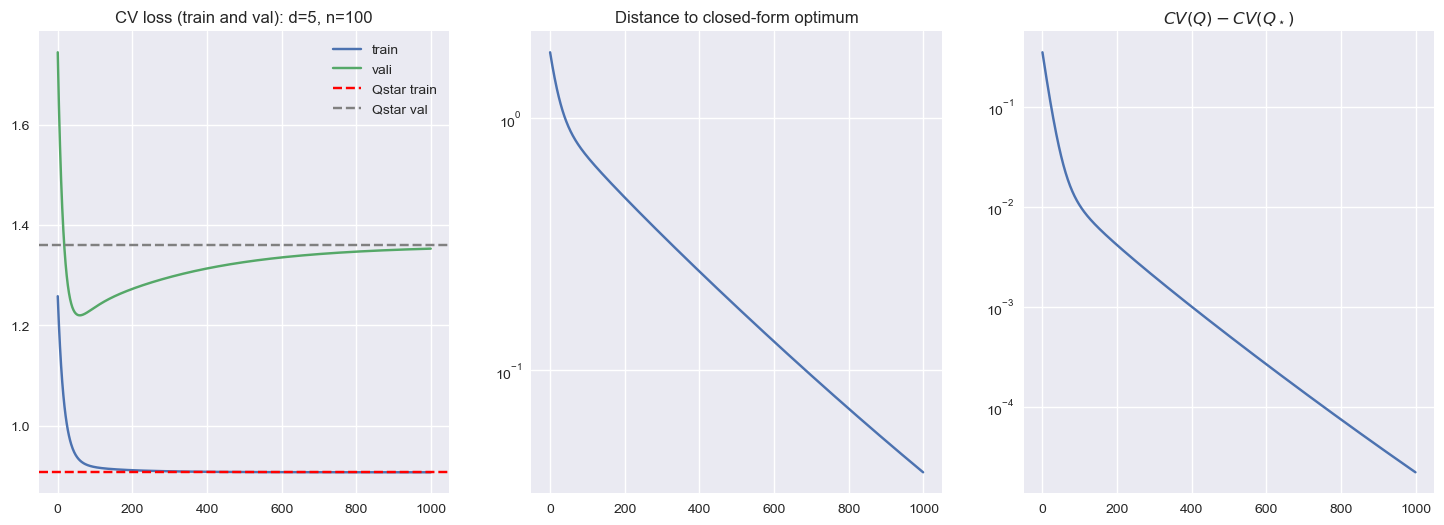

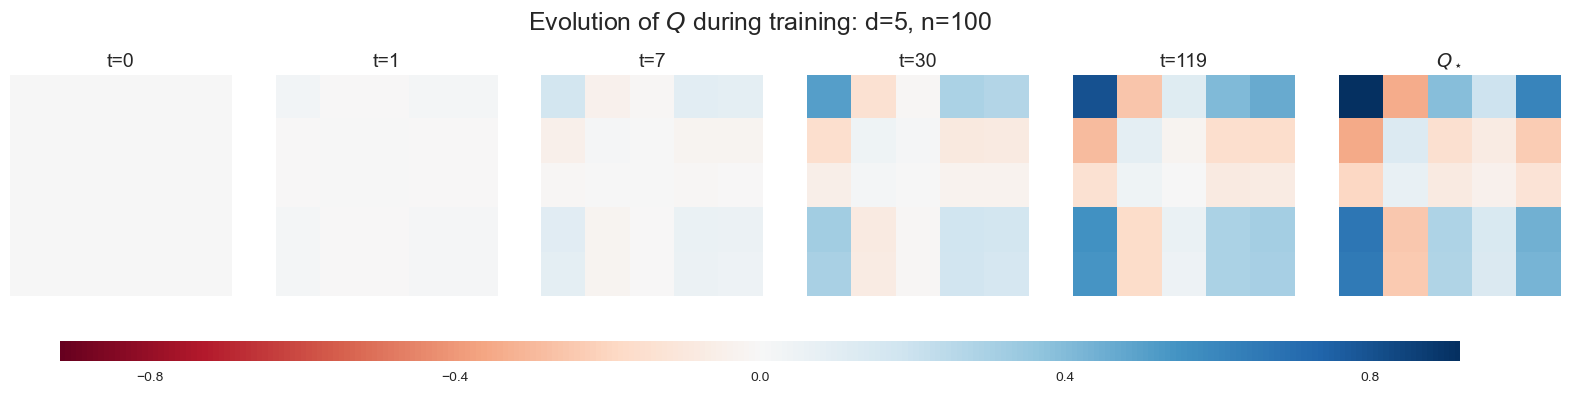

In [8]:
# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.1
n_iters = 1000
w_cov = np.eye(d)
noise_scale = 0.01
w0 = np.ones(d)
Q0 = np.ones((d,d)) * 0.001

# Training loop
crossvals, Qs, X, y, w_star = generate_data_and_train_Q(d, n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, noise_scale, seed=123)

# --- Plots ---
n_figures = 3
r = range(n_iters)   # range of indices to plot, separated out for easy modification
#r = range(n_iters//2)

# Compute stationarity gaps, crossvals on validation data
X_val = np.random.randn(n, d)
validation_crossvals = np.array([crossval(w0, Q, inner_lr, X_val, X_val @ w_star, ignore_diag=False) for Q in Qs[r]])

# Compute distance to optimum
Qstar = stationary_closed_form(X, w0, w_star, inner_lr)
d_Q_Qstar = np.linalg.norm(Qs - Qstar, axis=(1,2))

plt.figure(figsize=(n_figures * 6, 6))
# Plot crossvals
plt.subplot(1, n_figures, 1)
plt.title(f"CV loss (train and val): d={d}, n={n}")
plt.plot(crossvals[r], label="train")
plt.plot(validation_crossvals[r], label="vali")
plt.axhline(crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')
plt.axhline(crossval(w0, Qstar, inner_lr, X_val, X_val @ w_star, ignore_diag=False), label="Qstar val", linestyle='--', color='gray')
plt.legend()

# plot distance to optimum
plt.subplot(1, n_figures, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_Q_Qstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, n_figures, 3)
plt.title("$CV(Q) - CV(Q_\\star)$")
plt.plot(crossvals[r] - crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False))
plt.yscale('log')
plt.show()

plot_matrix_evolution(Qs[r], extra_matrix=Qstar, extra_matrix_title="$Q_\\star$", main_title=f"Evolution of $Q$ during training: d={d}, n={n}")

Gradient descent on $Q$ is learning the predicted closed-form solution. (Rightmost figure is closed-form solution; others are iterates converging to it.)

## Compare to a single step of gradient descent

In [9]:
d,n = 5, 500
lr = 0.1
w_cov = np.eye(d)
w0 = np.ones(d)
Q0 = np.eye(d)

X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale=0)
Qstar = stationary_closed_form(X, w0, w_star, lr)

trained_md_crossvals = []
gd_crossvals = []
X_vals = []
for i in np.arange(300):
    X_val = np.random.randn(n, d)
    y_val = X_val @ w_star
    trained_md_crossvals.append(crossval(w0, Qstar, lr, X_val, y_val))
    gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))
    X_vals.append(X_val)


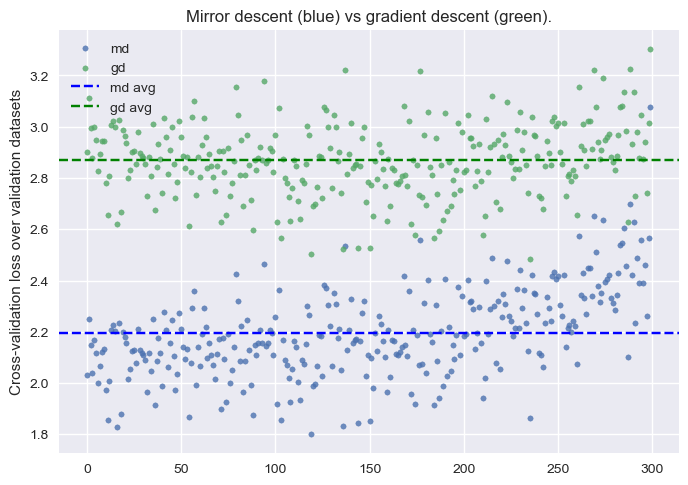

In [10]:
md_gd_crossvals = np.array([trained_md_crossvals, gd_crossvals])
sorted_indices = np.argsort(md_gd_crossvals[0])                        # sort by value of md crossval
sorted_indices = np.argsort(md_gd_crossvals[0] - md_gd_crossvals[1])   # sort by difference between crossvals
md_gd_crossvals = md_gd_crossvals[:, sorted_indices]
X_vals = np.array(X_vals)[sorted_indices]

plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[0], label="md", s=15, alpha=0.8)
plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[1], label="gd", s=15, alpha=0.8)
#plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[1] - md_gd_crossvals[0], alpha=0.5, linestyle='--', color='gray', label="diffs", s=15)
plt.axhline(y=np.mean(md_gd_crossvals[0]), label="md avg", color='blue', linestyle='--')
plt.axhline(y=np.mean(md_gd_crossvals[1]), label="gd avg", color='green', linestyle='--')
plt.ylabel("Cross-validation loss over validation datasets")
plt.title("Mirror descent (blue) vs gradient descent (green).")
plt.legend()
plt.show()

If the blue line is consistently below the green line, then we're seeing the effect of the MD step being better.

[  10.   12.   14.   16.   19.   22.   26.   30.   36.   42.   49.   57.
   67.   79.   92.  108.  127.  149.  174.  204.  240.  281.  329.  386.
  452.  530.  621.  728.  853. 1000.]


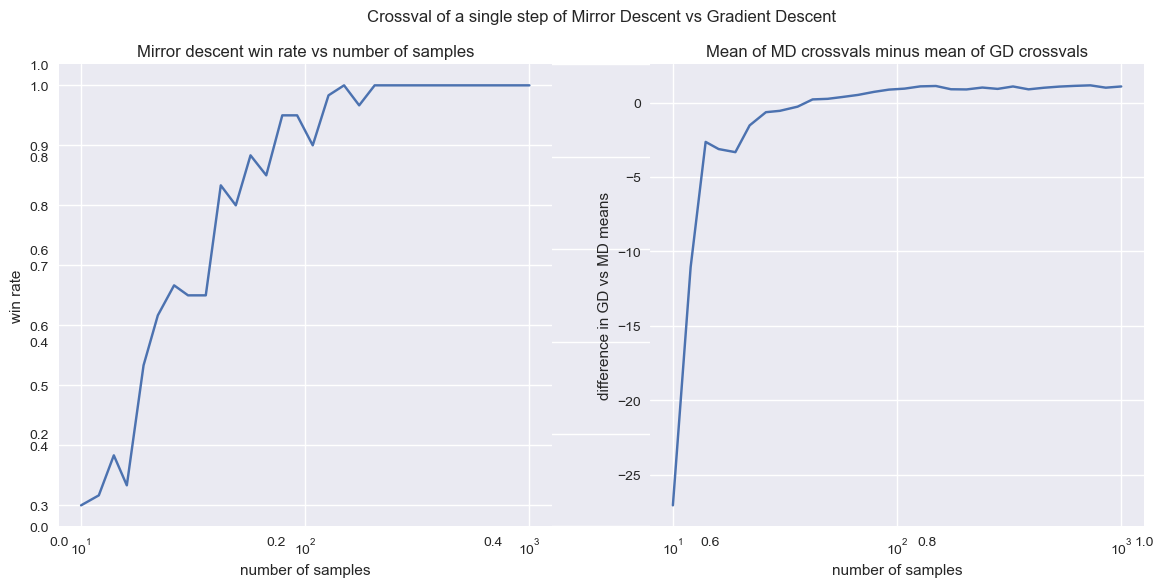

In [11]:
# n vs % of runs that MD wins
iters_per_size = 60
lr = 0.1
w0 = np.ones(d)

win_counts = []
mean_diffs = []

sizes = np.round(np.logspace(1, 3, 30))
print(sizes)
for n in sizes:
    n = int(n)
    qstar_crossvals = []
    gd_crossvals = []

    for i in np.arange(iters_per_size):
        X, y, w_star = generate_linear_data(d, n)
        Qstar = stationary_closed_form(X, w0, w_star, lr)

        X_val = np.random.randn(n, d)
        y_val = X_val @ w_star
        qstar_crossvals.append(crossval(w0, Qstar, lr, X_val, y_val))
        gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))

    md_gd_crossvals = np.array([qstar_crossvals, gd_crossvals])
    win_counts.append(np.mean(md_gd_crossvals[0] < md_gd_crossvals[1]))
    mean_diffs.append(np.mean(md_gd_crossvals[1] - md_gd_crossvals[0]))
    #print(f"Finished size n={n}")

plt.figure(figsize=(14, 6))
plt.title("Crossval of a single step of Mirror Descent vs Gradient Descent\n\n")
plt.subplot(1, 2, 1)
plt.plot(sizes, win_counts)
plt.xscale('log')
plt.xlabel("number of samples")
plt.ylabel("win rate")
plt.title("Mirror descent win rate vs number of samples")

plt.subplot(1, 2, 2)
plt.plot(sizes, mean_diffs)
plt.xscale('log')
plt.xlabel("number of samples")
plt.ylabel("difference in GD vs MD means")
plt.title("Mean of MD crossvals minus mean of GD crossvals")
plt.show()


### 2D plots: direction of MD vs GD step

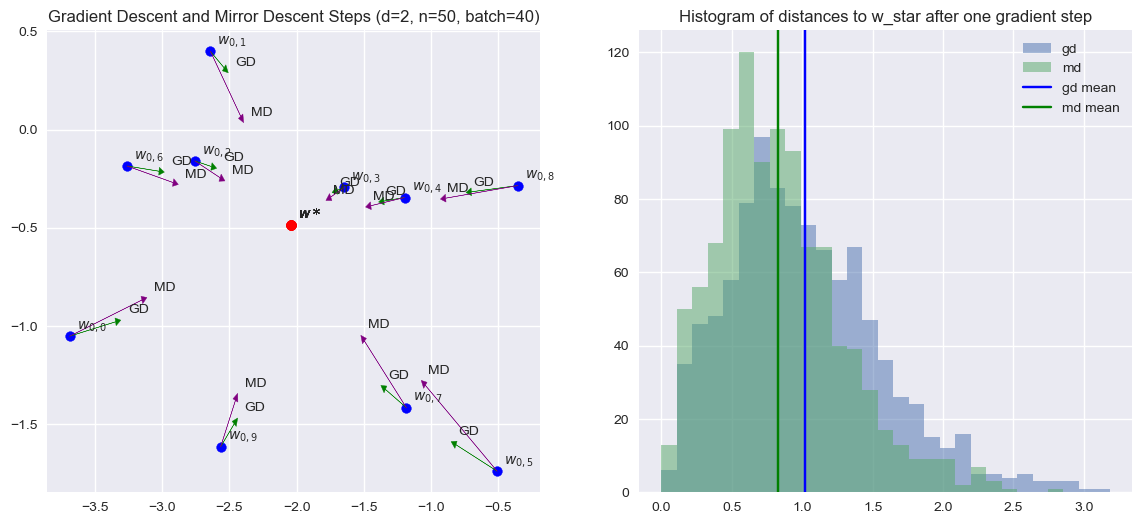

In [12]:
d,n = 2, 50
batch_size = 40
lr = 0.1
w_cov = np.eye(d)

X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale=0)
Q0 = np.eye(d)

X = X[:batch_size]
y = y[:batch_size]
gd_distances = []
md_distances = []

n_points_to_plot = 10
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title(f'Gradient Descent and Mirror Descent Steps (d={d}, n={n}, batch={batch_size})')
for i in range(1000):
    w0 = w_star + np.random.randn(d)
    Qstar = stationary_closed_form(X, w0, w_star, lr)
    gradient_step = mirror_descent_batch_step(w0, np.eye(d), lr, X, y)
    mirror_step = mirror_descent_batch_step(w0, Qstar, lr, X, y)

    gd_distances.append(np.linalg.norm(gradient_step - w_star))
    md_distances.append(np.linalg.norm(mirror_step - w_star))

    # only plot some points, show rest in histogram
    if i < n_points_to_plot:
        # Plot the original points
        plt.scatter(w0[0], w0[1], color='blue')
        plt.scatter(w_star[0], w_star[1], color='red')

        # Plot the step points
        #plt.scatter(gradient_step[0], gradient_step[1], color='green')
        #plt.scatter(mirror_step[0], mirror_step[1], color='purple')

        # Add arrows
        plt.arrow(w0[0], w0[1], gradient_step[0]-w0[0], gradient_step[1]-w0[1], 
                head_width=0.04, head_length=0.04, fc='green', ec='green', length_includes_head=True)
        plt.arrow(w0[0], w0[1], mirror_step[0]-w0[0], mirror_step[1]-w0[1], 
                head_width=0.04, head_length=0.04, fc='purple', ec='purple', length_includes_head=True)

        # Add labels
        plt.annotate(f'$w_{{0,{i}}}$', (w0[0], w0[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate('$w*$', (w_star[0], w_star[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate(f'GD', (gradient_step[0], gradient_step[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate('MD', (mirror_step[0], mirror_step[1]), xytext=(5, 5), textcoords='offset points')


max_dist = max(np.max(gd_distances), np.max(md_distances))
bins = list(np.linspace(0, max_dist, 30))
plt.subplot(1,2,2)
plt.hist(gd_distances, alpha=0.5, bins=bins, label="gd")
plt.hist(md_distances, alpha=0.5, bins=bins, label="md")
plt.axvline(np.mean(gd_distances), color="blue", label="gd mean")
plt.axvline(np.mean(md_distances), color="green", label="md mean")
plt.legend()
plt.title("Histogram of distances to w_star after one gradient step")
plt.show()

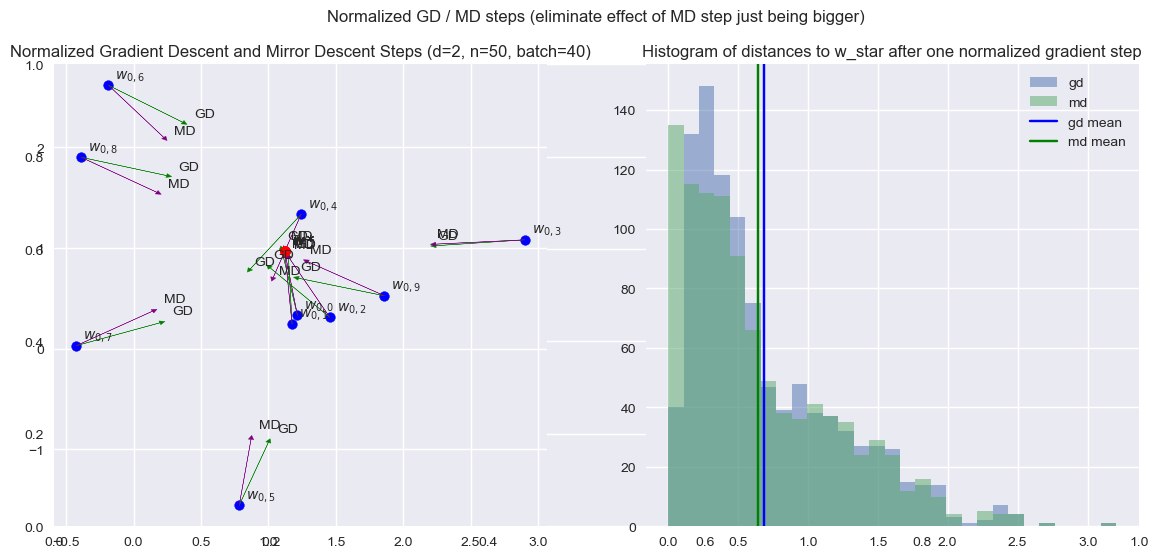

In [13]:
# same thing, but normalize the step size so we're really just seeing effect of direction
d,n = 2, 50
batch_size = 40
lr = 0.1
scale = 0.7
w_cov = np.eye(d)

X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale=0)
Q0 = np.eye(d)

X = X[:batch_size]
y = y[:batch_size]
gd_distances = []
md_distances = []

n_points_to_plot = 10
plt.figure(figsize=(14, 6))
plt.title("Normalized GD / MD steps (eliminate effect of MD step just being bigger)\n\n")
plt.subplot(1,2,1)
plt.title(f'Normalized Gradient Descent and Mirror Descent Steps (d={d}, n={n}, batch={batch_size})')
for i in range(1000):
    w0 = w_star + np.random.randn(d)
    Qstar = stationary_closed_form(X, w0, w_star, lr)
    gradient_step = w0 - mirror_descent_batch_step(w0, np.eye(d), lr, X, y)
    mirror_step = w0 - mirror_descent_batch_step(w0, Qstar, lr, X, y)

    # ONLY CHANGE FROM ABOVE: normalize distance between iterates
    gradient_step = w0 - gradient_step / np.linalg.norm(gradient_step) * scale
    mirror_step = w0 - mirror_step / np.linalg.norm(mirror_step) * scale

    gd_distances.append(np.linalg.norm(gradient_step - w_star))
    md_distances.append(np.linalg.norm(mirror_step - w_star))

    # only plot some points, show rest in histogram
    if i < n_points_to_plot:
        # Plot the original points
        plt.scatter(w0[0], w0[1], color='blue')
        plt.scatter(w_star[0], w_star[1], color='red')

        # Plot the step points
        #plt.scatter(gradient_step[0], gradient_step[1], color='green')
        #plt.scatter(mirror_step[0], mirror_step[1], color='purple')

        # Add arrows
        plt.arrow(w0[0], w0[1], gradient_step[0]-w0[0], gradient_step[1]-w0[1], 
                head_width=0.04, head_length=0.04, fc='green', ec='green', length_includes_head=True)
        plt.arrow(w0[0], w0[1], mirror_step[0]-w0[0], mirror_step[1]-w0[1], 
                head_width=0.04, head_length=0.04, fc='purple', ec='purple', length_includes_head=True)

        # Add labels
        plt.annotate(f'$w_{{0,{i}}}$', (w0[0], w0[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate('$w*$', (w_star[0], w_star[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate(f'GD', (gradient_step[0], gradient_step[1]), xytext=(5, 5), textcoords='offset points')
        plt.annotate('MD', (mirror_step[0], mirror_step[1]), xytext=(5, 5), textcoords='offset points')


max_dist = max(np.max(gd_distances), np.max(md_distances))
bins = list(np.linspace(0, max_dist, 30))
plt.subplot(1,2,2)
plt.hist(gd_distances, alpha=0.5, bins=bins, label="gd")
plt.hist(md_distances, alpha=0.5, bins=bins, label="md")
plt.axvline(np.mean(gd_distances), color="blue", label="gd mean")
plt.axvline(np.mean(md_distances), color="green", label="md mean")
plt.legend()
plt.title("Histogram of distances to w_star after one normalized gradient step")
plt.show()

## Graphs for mixed $w$ 

Questions:
* Are there consistent, visible patterns in $Q$?
* What properties are preseved between multiple runs with different data?
* How does $\Sigma_w$ itself perform as a mirror map?

### Generic "run experiment" function

In [14]:
def potential_training_loop_mixed_w(d, n_samples_per_w, n_ws, inner_lr, outer_lr, w0, Q0, n_iters,
                                    w_cov=None, noise_scale=0.):
    
    X, y, W_stars = generate_mixed_linear_data(d, n_samples_per_w, n_ws, w_cov, noise_scale)

    Q = Q0.copy()
    crossvals = np.zeros(n_iters)
    Qs = np.zeros((n_iters, d, d))
    for i in range(n_iters):
        Qs[i] = Q.copy()
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=True)
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)

    return crossvals, Qs, X, y, W_stars

## Expected Stationary Point

Row and column averages of xval matrix:  
      col avgs:  [1.34 0.83 0.42 3.07 0.32 1.05 0.47 0.56 0.11 1.91]
      row avgs:  [1.02 1.07 1.05 0.89 1.07 0.94 1.07 1.06 0.95 0.96]
       overall:  1.01

Xval of 'expected stationary point':
      all values: [ 73.53  25.88  11.25 151.48  14.25  27.77  17.12  17.27   4.58  59.31]
             avg: 40.24

Xval using average of all Qstars:
      all values: [1.02 0.71 0.36 2.34 0.26 0.9  0.4  0.47 0.09 1.6 ]
             avg: 0.82

Xval using random gaussian:
      all values: [2.41 1.3  0.64 4.54 0.59 1.64 0.76 0.84 0.18 2.81]
             avg: 1.57

Xval using identity matrix:
      all values: [1.01 0.67 0.35 2.38 0.25 0.92 0.39 0.48 0.09 1.65]
             avg: 0.82


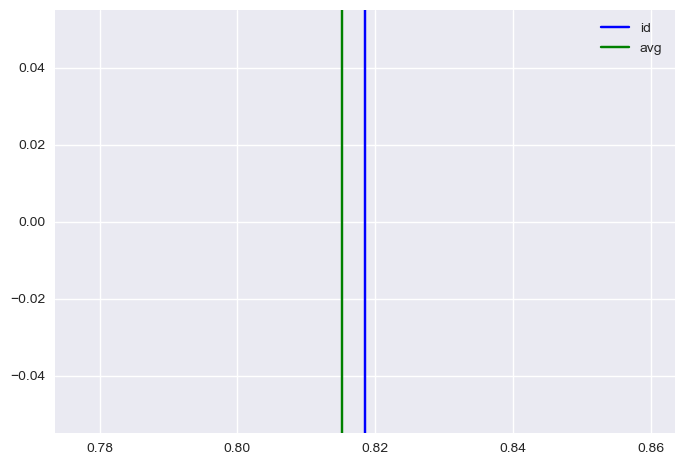

In [15]:
def expected_stationary_point(w0, w_cov, x_cov, lr):
    """w_cov is z_cov really"""
    term1 = 2 * x_cov @ w_cov @ x_cov
    term2 = np.trace(x_cov @ w_cov) * x_cov
    inv = np.linalg.inv(term1 + term2)
    return w_cov @ x_cov @ inv

# def expected_stationary_point(w0, w_cov, x_cov, lr):
#     # Compute intermediate terms
#     w0_col = w0.reshape(-1, 1)  # reshape w0 to a column vector (d, 1)
#     w0_row = w0.reshape(1, -1)  # reshape w0 to a row vector (1, d)

#     term1 = np.dot(np.dot(w0_row, x_cov), w0_col) * x_cov
#     term2 = np.dot(np.dot(w0_row, x_cov), w0_col).item() * x_cov
#     term3 = np.trace(np.dot(w_cov, x_cov)) * x_cov

#     # Compute the inverse term
#     inv_term = np.linalg.inv(term1 + term2 + term3)

#     # Compute w0w0^T + Sigma_w
#     w0w0T_plus_w_cov = np.dot(w0_col, w0_row) + w_cov

#     # Compute Q
#     return (1 / (2 * lr)) * np.dot(np.dot(x_cov, w0w0T_plus_w_cov), inv_term)

d, n = 5, 100
n_datasets = 10
x_cov = np.diag([1]*2 + [0]*(d-2)) + 0.01 * np.eye(d)
w_cov = np.diag([0]*3 + [1]*(d-3)) + 0.01 * np.eye(d) 
w0 = np.zeros(d)
lr = 0.1

EQstar = expected_stationary_point(w0, w_cov, x_cov, lr)

# generate a bunch of datasets
Xs, ys, w_stars = [], [], []
Qstars = []
for _ in range(n_datasets):
    X, y, w_star = generate_linear_data(d, n, w_cov, x_cov)
    Xs.append(X); ys.append(y); w_stars.append(w_star)
    Qstars.append(stationary_closed_form(X, w0, w_star, lr))
Xs = np.array(Xs); ys = np.array(ys); w_stars = np.array(w_stars)
Qstars = np.array(Qstars)

# evaluate crossval of each dataset's Q* against the other datasets
xvals_array = np.array([[crossval(w0, Qstars[i], lr, Xs[j], ys[j], ignore_diag=False) for j in range(n_datasets)] for i in range(n_datasets)]) 
# for i in range(n_datasets):
#     for j in range(n_datasets):
#         assert xvals_array[i, j] == crossval(w0, Qstars[i], lr, Xs[j], ys[j])

# evaluate EQstar against each dataset
eq_xvals = np.array([crossval(w0, EQstar, lr, X, y) for (X, y) in zip(Xs, ys)])

# evaluate against a random matrix
randQ = np.random.randn(d,d)
rand_xvals = np.array([crossval(w0, randQ, lr, X, y) for (X, y) in zip(Xs, ys)])

# average all the Qstars because uhh idk that's something you can do
avg_Qstar = Qstars.mean(axis=0)
avg_xvals = np.array([crossval(w0, avg_Qstar, lr, X, y) for (X, y) in zip(Xs, ys)])

# identity matrix
id_xvals = np.array([crossval(w0, np.eye(d), lr, X, y) for (X, y) in zip(Xs, ys)])

# ---- display results -----
print("Row and column averages of xval matrix:  ")
print("      col avgs: ", xvals_array.mean(0).round(2))
print("      row avgs: ", xvals_array.mean(1).round(2))
print("       overall: ", xvals_array.mean().round(2))
print("\nXval of 'expected stationary point':")
print("      all values:", eq_xvals.round(2))
print("             avg:", eq_xvals.mean().round(2))
print("\nXval using average of all Qstars:")
print("      all values:", avg_xvals.round(2))
print("             avg:", avg_xvals.mean().round(2))
print("\nXval using random gaussian:")
print("      all values:", rand_xvals.round(2))
print("             avg:", rand_xvals.mean().round(2))
print("\nXval using identity matrix:")
print("      all values:", id_xvals.round(2))
print("             avg:", id_xvals.mean().round(2))


# histograms
xval_lists = {"id":id_xvals, "avg":avg_xvals}
colors = ['blue', 'green', 'orange', 'red', 'black']
max_xval = np.max(list(xval_lists.values()))
bins = list(np.linspace(0, max_xval, n_datasets//10))
for xv, color in zip(xval_lists, colors):
    plt.hist(xval_lists[xv], alpha=0.3, bins=bins, color=color, label=xv)
    plt.axvline(xval_lists[xv].mean(), color=color, label=xv)
plt.legend()
plt.show()

# plot_matrix_evolution(np.array([x_cov, w_cov]), n_images=2, t_scale='linear')
# plt.imshow(EQstar)
# plt.colorbar(); plt.grid(0); plt.show()
# plot_matrix_evolution(Qstars, n_images=n_datasets, t_scale='linear')

# plt.subplot(1, 2, 1)
# plt.imshow(xvals_array)
# plt.xlabel("train")
# plt.ylabel("eval")
# plt.colorbar()
# plt.grid(0)

# plt.subplot(1, 2, 2)
# plt.imshow(eq_xvals[:, np.newaxis])
# plt.grid(0)
# plt.colorbar()

# plt.show()

# $UU^\top$ parameterization

## Basic training loop

In [16]:
def mirror_descent_step_U(w: np.ndarray, U: np.ndarray, lr: float, x: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.
    Just calls `mirror_descent_step` with `Q = U @ U.T`.

    [ 7.1: this function isn't actually used right now, since the potential update computes this manually ]

    Args:
        w: Current weight vector (d_feature, 1).
        U: Factor of potential matrix: Q = U @ U.T
        lr: Learning rate.
        x: Feature vector (d_feature,).
        y: Target value.

    Returns:
        Updated weight vector (d_feature,).
    """
    return mirror_descent_step(w, U @ U.T, lr, x, y)


def crossval_U(w: np.ndarray, U: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.
    Just calls `crossval` with `Q = U @ U.T`.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        U: Factor of potential matrix: Q = U @ U.T
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    return crossval(w, U @ U.T, lr, X, y, ignore_diag)

def potential_update_U(w: np.ndarray, U: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                       ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix U based on the derivative of the cross-validation loss, where Q = UU^T.

    Args:
        w: Current weight vector (d_feature,).
        U: Current potential matrix factor (d_feature, d_feature).
        outer_lr: Learning rate for updating U.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).
        ignore_diag: Whether to ignore diagonal terms in the loss calculation.

    Returns:
        Updated potential matrix factor U (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    denom = n_samples ** 2
    
    errors = X @ w - y
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * X @ U @ U.T @ X.T
    
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom -= n_samples

    L_errors = L * errors[:, np.newaxis]  # (n_samples, n_samples)
    update = X.T @ (L_errors + L_errors.T) @ X @ U
    
    # Apply scaling factor
    update *= -2 * inner_lr / denom
    assert update.shape == U.shape, f"Potential update of shape {update.shape} is incompatible with U shape of {U.shape}."
    
    # Update U using gradient descent
    return U - outer_lr * update

In [17]:
def potential_training_loop_U(X, y, inner_lr, outer_lr, w0, U0, n_iters):
    """
    Basic training loop/
    """
    Us = [U0.copy()]
    crossvals = [crossval_U(w0, U0, inner_lr, X, y, ignore_diag=False)]
    U = U0.copy()
    for i in range(n_iters):
        U = potential_update_U(w0, U, outer_lr, inner_lr, X, y, ignore_diag=False)
        Us.append(U.copy())
        crossvals.append(crossval_U(w0, U, inner_lr, X, y, ignore_diag=False))

    Us = np.array(Us)
    crossvals = np.array(crossvals)

    return crossvals, Us


def generate_data_and_train_U(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                              w_cov=None, noise_scale=0., seed=None):
    """
    Simpler training loop, which also generates data to eliminate another line of code later on. 
    """
    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)
    crossvals, Us = potential_training_loop_U(X, y, inner_lr, outer_lr, w0, Q0, n_iters)

    return crossvals, Us, X, y, w_star

### Claude's numerical correctness check for `potential_update_U` 

In [18]:
from scipy.linalg import eigvalsh

def numerical_gradient(w, U, inner_lr, X, y, epsilon=1e-8):
    """Compute numerical gradient of CV loss with respect to U."""
    grad = np.zeros_like(U)
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            U_plus = U.copy()
            U_plus[i, j] += epsilon
            U_minus = U.copy()
            U_minus[i, j] -= epsilon
            grad[i, j] = (crossval_U(w, U_plus, inner_lr, X, y) - 
                          crossval_U(w, U_minus, inner_lr, X, y)) / (2 * epsilon)
    return grad


def test_potential_update_U():
    # Generate random data
    n_samples, d_feature = 20, 5
    X = np.random.randn(n_samples, d_feature)
    w = np.random.randn(d_feature)
    y = X @ w + np.random.randn(n_samples) * 0.1
    U = np.random.randn(d_feature, d_feature)
    
    # Set learning rates
    outer_lr, inner_lr = 0.01, 0.1
    
    # Compute update using our function
    U_new = potential_update_U(w, U, outer_lr, inner_lr, X, y)
    actual_update = (U_new - U) / outer_lr
    
    # Compute numerical gradient
    numerical_grad = numerical_gradient(w, U, inner_lr, X, y)
    
    # Compare the results
    assert_allclose(actual_update, -numerical_grad, rtol=1e-4, atol=1e-4,
                    err_msg="Gradient from potential_update_U doesn't match numerical gradient")
    
    # Check if the resulting Q is positive semidefinite
    Q_new = U_new @ U_new.T
    min_eigenvalue = eigvalsh(Q_new).min()
    assert min_eigenvalue >= -1e-10, f"Resulting Q is not positive semidefinite. Min eigenvalue: {min_eigenvalue}"
    
    print("All tests passed!")

# Run the test
test_potential_update_U()

All tests passed!


## Closed-form optimum, stationarity conditions

In [19]:
def stationarity_condition_UUT_full(UUT, X, w, w_star, lr, return_pair=False):
    """
    Consistent with stationary_closed_form below.

    This check implicitly cancels the U on the end of the lhs and rhs.
    If you want to keep that U aruond, use `stationarity_condition_U_full`.
    """
    errors = X @ (w - w_star)  # (n,)
    E2 = np.diag(errors)**2  # (n, n)
    XTe = X.T @ errors  # (d,)
    xuuxe = X @ UUT @ X.T @ E2

    lhs = np.outer(XTe, XTe) # (d,d)
    rhs = lr * X.T @ (xuuxe + xuuxe.T) @ X
    if return_pair:
        return lhs, rhs
    return lhs - rhs 

def stationarity_condition_U_full(U, X, w, w_star, lr, return_pair=False):
    """
    Haven't directly tested this, but the UUT version works and is almost identical.
    
    This version doesn't implicitly cancel a U, so it might be preferable if you have access to U.
    """
    errors = X @ (w - w_star)  # (n,)
    E2 = np.diag(errors)**2  # (n, n)
    XTe = X.T @ errors  # (d,)
    xuuxe = X @ U @ U.T @ X.T @ E2

    lhs = np.outer(XTe, XTe) @ U # (d,d)
    rhs = lr * X.T @ (xuuxe + xuuxe.T) @ X @ U
    if return_pair:
        return lhs, rhs
    return lhs - rhs   


def stationary_closed_form_UUT(X, w, w_star, lr):
    """
    Currently passing all tests!

    Returns the matrix Q = UU^T that falls out of solving dCV/dU = 0.
    Assumptions: U, X^T E X, and X^T X are invertible.
    """
    n, d = X.shape

    # Define variables
    z = w - w_star
    E2 = np.diag(X @ z)**2   # E squared
    A = X.T @ X
    B = X.T @ E2 @ X
    A_inv = np.linalg.inv(A)
    
    # Set up and solve the Sylvester equation
    SA = A_inv @ B
    SB = B @ A_inv
    C = np.outer(z, z)
    UUT = solve_sylvester(SA, SB, C)
    return UUT / lr

In [20]:
def test_stationary_closed_form_U():
    d, n, lr = 5, 10, 0.1
    X, y, w_star = generate_linear_data(d, n)
    w0 = np.ones((d,))
    UUT_star = stationary_closed_form_UUT(X, w0, w_star, lr)
    lhs, rhs = stationarity_condition_UUT_full(UUT_star, X, w0, w_star, lr, return_pair=True)
    try:
        assert_allclose(lhs, rhs)
    except AssertionError as e:
        print("assert_allclose failed: Closed-form matrix isn't passing stationary condition.")
        print(e) 

test_stationary_closed_form_U()

## Graphs for single $w$

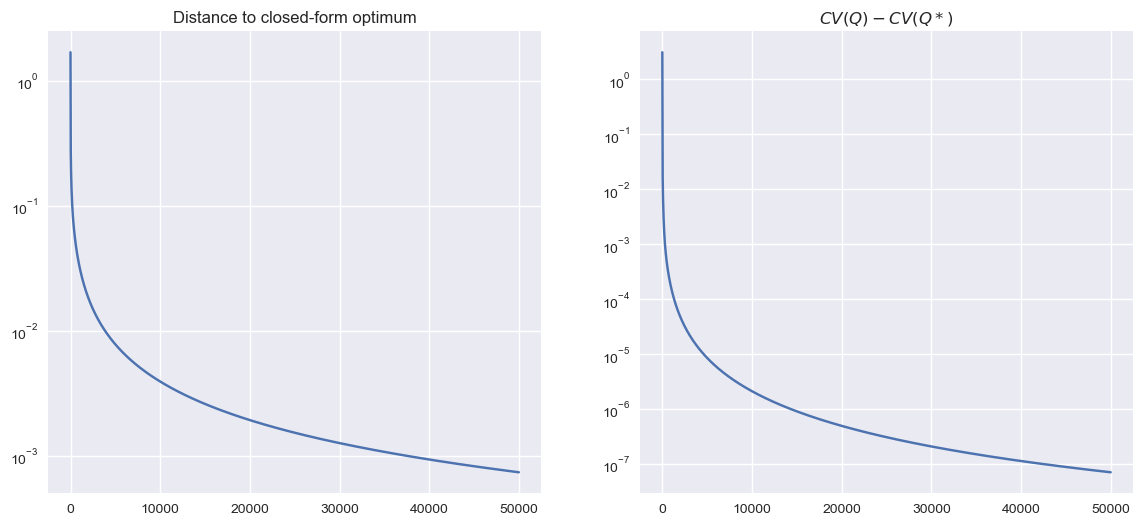

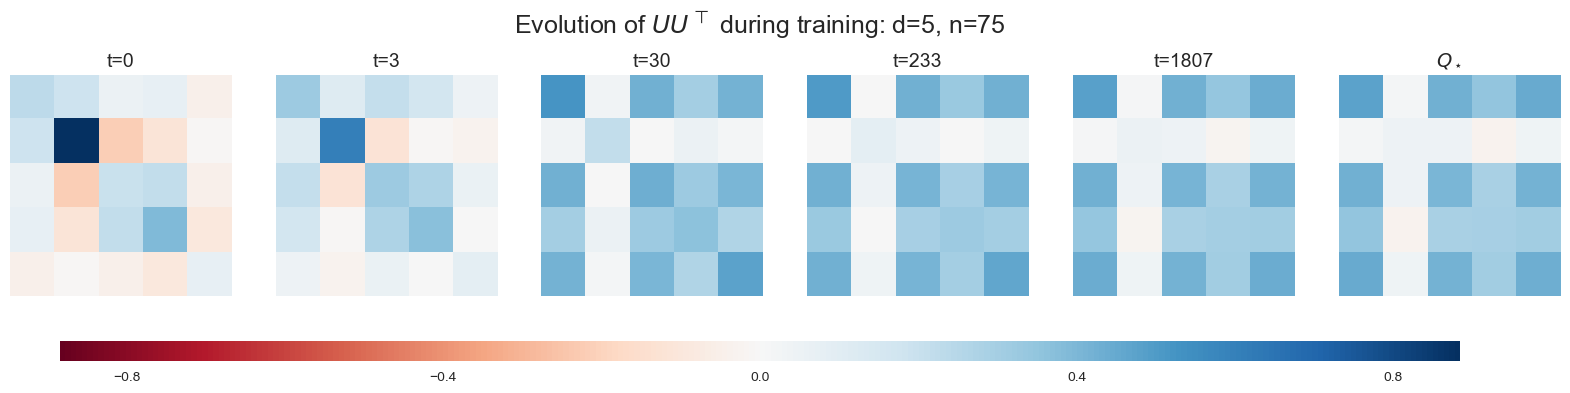

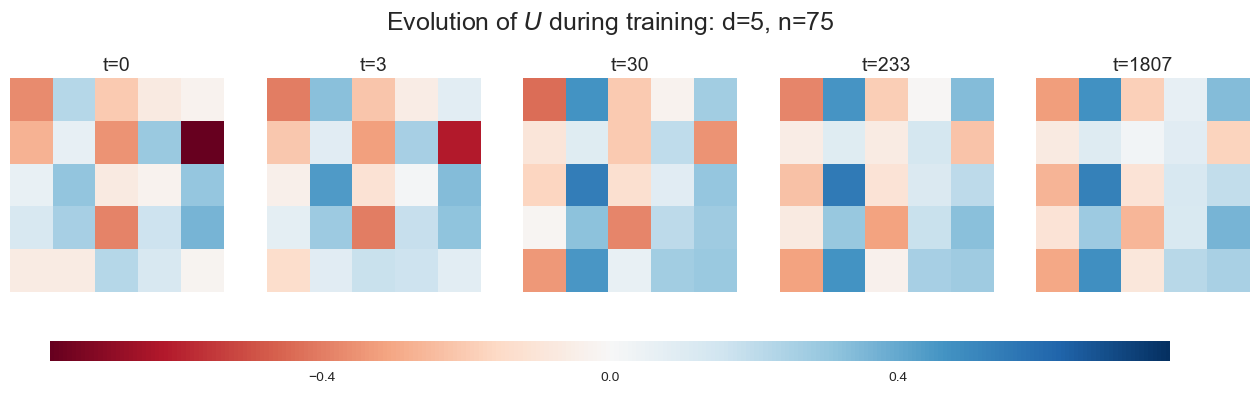

In [21]:
# Training setup
d,n = 5, 75
rank = 5
inner_lr, outer_lr = 0.1, 0.03
n_iters = 50000
w_cov = np.eye(d)
w0 = np.ones(d)
U0 = 0.0001 * np.eye(d)
U0 =  np.random.randn(d, rank) / d ** 0.7

# Training loop
crossvals, Us, X, y, w_star = generate_data_and_train_U(d, n, inner_lr, outer_lr, w0, U0, n_iters, w_cov)

UUTstar = stationary_closed_form_UUT(X, w0, w_star, inner_lr)
UUTs = np.array([U @ U.T for U in Us])

# Compute distance to optimum
d_UUT_UUTstar = np.linalg.norm(UUTs - UUTstar, axis=(1,2))
r = range(n_iters)

plt.figure(figsize=(14, 6))
# plot distance to optimum
plt.subplot(1, 2, 1)
plt.title("Distance to closed-form optimum")
plt.plot(d_UUT_UUTstar[r])
plt.yscale('log')

# diff between CV and UUTstar CV
plt.subplot(1, 2, 2)
plt.title("$CV(Q) - CV(Q*)$")
plt.plot((crossvals[r] - crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False)))
plt.yscale('log')

plot_matrix_evolution(UUTs[r], main_title=f"Evolution of $UU^\\top$ during training: d={d}, n={n}",
                      extra_matrix=UUTstar, extra_matrix_title=f"$Q_\\star$")
plot_matrix_evolution(Us[r], main_title=f"Evolution of $U$ during training: d={d}, n={n}")

### Eigenvalue / singular value alignment

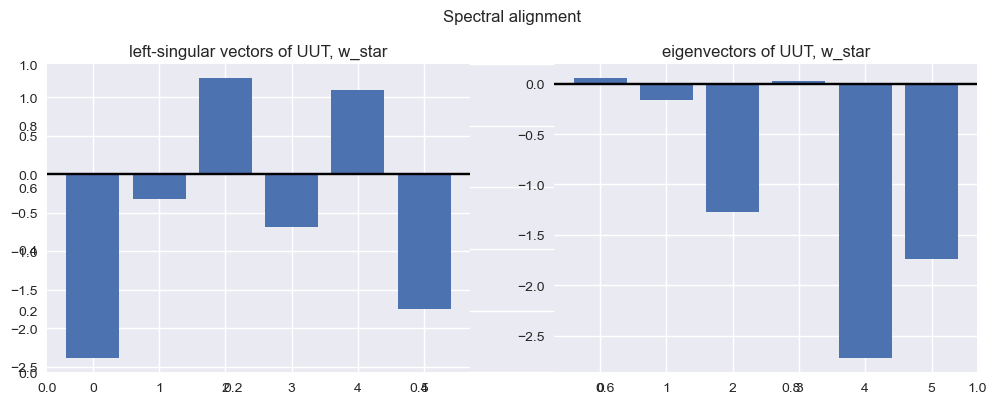

In [22]:
# Training setup
d,n = 6, 100
lr = 0.5
w_cov = np.eye(d)
w0 = np.ones(d)
X, y, w_star = generate_linear_data(d, n, w_cov)

UUTstar = stationary_closed_form_UUT(X, w0, w_star, lr)
svdU, svdS, svdV = np.linalg.svd(UUTstar)
eigs = np.linalg.eigh(UUTstar)


n_figs = 2
plt.figure(figsize=(n_figs * 4 + 4, 4))
plt.title("Spectral alignment\n\n")

plt.subplot(1, n_figs, 1)
plt.bar(x=np.arange(d), height=np.inner(w_star, svdU))
plt.title("left-singular vectors of UUT, w_star")
plt.axhline(color='black')

plt.subplot(1, n_figs, 2)
plt.bar(x=np.arange(d), height=np.inner(w_star, eigs.eigenvectors))
plt.title("eigenvectors of UUT, w_star")
plt.axhline(color='black')
plt.show()

### Effect of initialization on $UU^T_\star$ (result: no observed effect on final iterate)

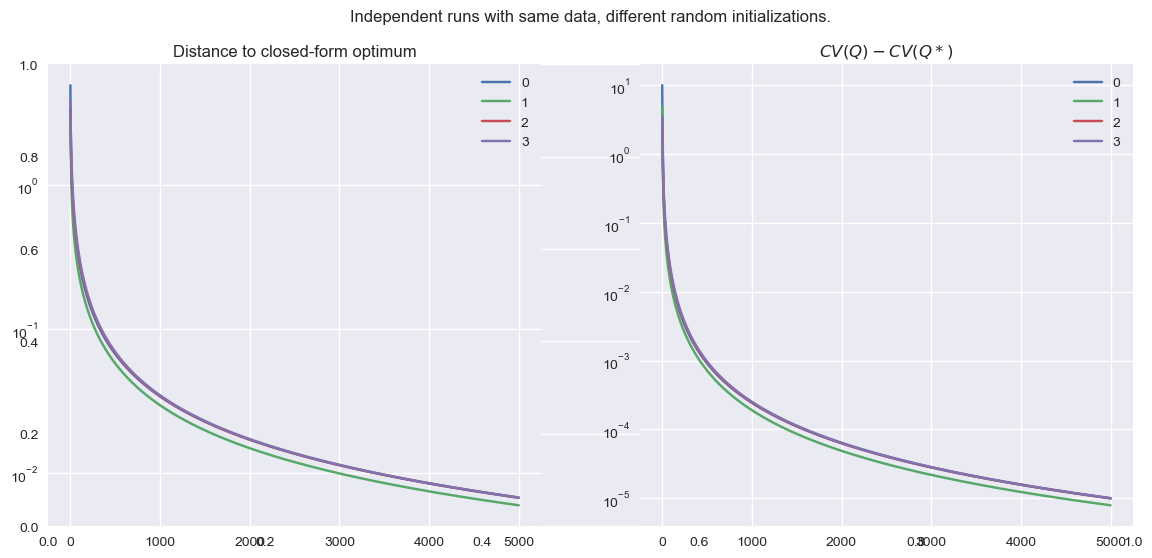

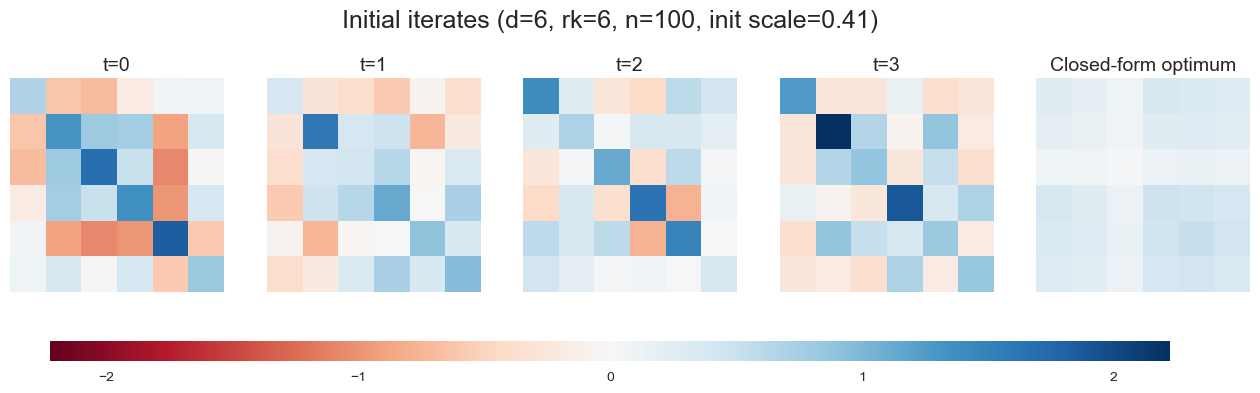

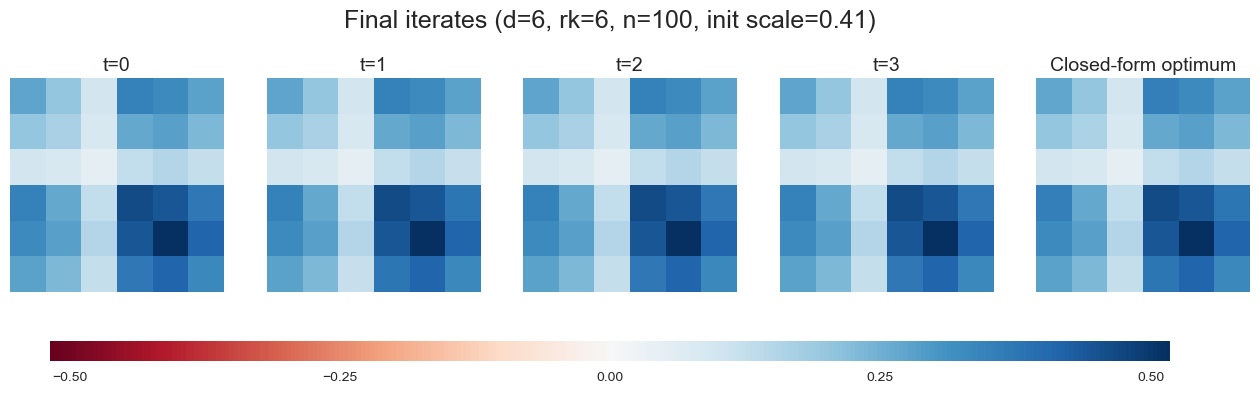

In [23]:
# Training setup
d,n = 6, 100
rank = 6
inner_lr, outer_lr = 0.1, 0.03
n_iters = 5000
w_cov = np.eye(d)
w0 = np.ones(d)

# Generate *fixed* data for several training loops
X, y, w_star = generate_linear_data(d, n, w_cov)

# Setting up U intializations
n_initializations = 4
init_scale = d ** (-0.5)

all_Us = []
all_UUTs = []
all_crossvals = []
UUTstars = []
for i in range(n_initializations):
    U0 =  np.random.randn(d, rank) * init_scale
    crossvals, Us = potential_training_loop_U(X, y, inner_lr, outer_lr, w0, U0, n_iters)
    UUTstar = stationary_closed_form_UUT(X, w0, w_star, inner_lr)
    UUTs = np.array([U @ U.T for U in Us])

    all_Us.append(Us)
    all_UUTs.append(UUTs)
    all_crossvals.append(crossvals)

    #plot_matrix_evolution(UUTs[:100] + UUTs[-1], main_title=f"Evolution of $UU^\\top$ during training: d={d}, n={n}", extra_matrix=UUTstar, extra_matrix_title=f"$Q_\\star$")
    #plot_matrix_evolution(Us[r], main_title=f"Evolution of $U$ during training: d={d}, n={n}")

all_Us = np.array(all_Us)      # (n_initializations, n_iters, d, rank)
all_UUTs = np.array(all_UUTs)  # (n_initializations, n_iters, d, d)
all_crossvals = np.array(all_crossvals)   # (n_initializations, n_iters)

plt.figure(figsize=(14, 6))
plt.title("Independent runs with same data, different random initializations.\n\n")
for i in range(n_initializations):
    # Compute distance to optimum
    d_UUT_UUTstar = np.linalg.norm(all_UUTs[i] - UUTstar, axis=(-2,-1))

    # plot distance to optimum
    plt.subplot(1, 2, 1)
    plt.title("Distance to closed-form optimum")
    plt.plot(d_UUT_UUTstar, label=f"{i}")
    plt.yscale('log')
    plt.legend()

    # diff between CV and UUTstar CV
    plt.subplot(1, 2, 2)
    plt.title("$CV(Q) - CV(Q*)$")
    plt.plot((all_crossvals[i] - crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False)), label=f"{i}")
    plt.yscale('log')
    plt.legend()
plt.show()

plot_matrix_evolution(all_UUTs[:, 0, :, :], main_title=f"Initial iterates (d={d}, rk={rank}, n={n}, init scale={init_scale:.2f})", t_scale='linear', 
                      extra_matrix=UUTstar, extra_matrix_title="Closed-form optimum", n_images=n_initializations)
plot_matrix_evolution(all_UUTs[:, -1, :, :], main_title=f"Final iterates (d={d}, rk={rank}, n={n}, init scale={init_scale:.2f})", t_scale='linear',
                      extra_matrix=UUTstar, extra_matrix_title="Closed-form optimum", n_images=n_initializations)

# ANNEX. 
**Code that's likely temporary, and I don't want it to be in the way anywhere else. Proceed with caution.**

### Inefficient Sylvester equation solver
Use matrix-vector form of the Sylvester equation to solve "by hand".

Advantages:
* Very easy to see what's going on.

Disadvantages:
* $O((mn)^3)$ runtime
* $O((mn)^2)$ space to store Kronecker product
* Examples that take scipy less than a second will nearly crash my computer if given to my implementation (e.g. 300 x 400)

In [24]:
def my_sylvester(A, B, C):
    n, m = C.shape
    In, Im = np.eye(n), np.eye(m)
    kron = np.kron(Im, A) + np.kron(B.T, In)
    print(kron.shape)
    vec_C = C.T.flatten()

    vec_X = np.linalg.solve(kron, vec_C)
    return vec_X.reshape(m, n).T

m, n = 10, 20
A = np.random.randn(n,n)
B = np.random.randn(m,m)
C = np.random.randn(n,m)
start = perf_counter()
myX = my_sylvester(A, B, C)
mid = perf_counter()
sciX = solve_sylvester(A, B, C)
end = perf_counter()

assert_allclose(myX, sciX)
print("Times:")
print(f"  My implementation:    {mid - start:.8f}")
print(f"  Scipy implementation: {end - mid:.8f}")

(200, 200)
Times:
  My implementation:    0.00575879
  Scipy implementation: 0.00245396


# final cell

In [25]:
print(f"Time elapsed to run whole notebook: {perf_counter() - NOTEBOOK_START_TIME:.2f} seconds")

Time elapsed to run whole notebook: 14.52 seconds
